In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
from collections import Counter
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)



In [ ]:
def data_transforms(phase=None):
    if phase == 'train':
        data_T = tt.Compose([
            tt.Resize(size=(256, 256)),
            tt.RandomRotation(degrees=(-20, +20)),
            tt.CenterCrop(size=224),
            tt.Grayscale(num_output_channels=3),
            tt.ToTensor(),
            tt.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
        ])
    elif phase in ['val', 'test']:
        data_T = tt.Compose([
            tt.Resize(size=(224, 224)),
            tt.Grayscale(num_output_channels=3),
            tt.ToTensor(),
            tt.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
        ])
    else:
        raise ValueError("phase must be 'train', 'val', or 'test'")
    return data_T

Class to index mapping: {'NORMAL': 0, 'PNEUMONIA': 1}


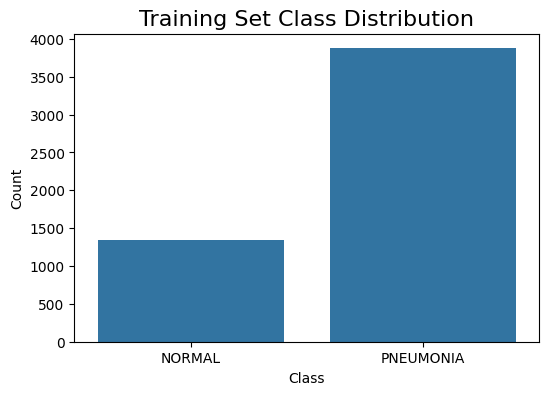

In [ ]:
#Datasets, DataLoaders, and class distribution

data_dir = "chest_xray"

# ImageFolder datasets
trainset = ImageFolder(os.path.join(data_dir, 'train'),
                       transform=data_transforms('train'))
validset = ImageFolder(os.path.join(data_dir, 'val'),
                       transform=data_transforms('val'))
testset  = ImageFolder(os.path.join(data_dir, 'test'),
                       transform=data_transforms('test'))

# DataLoaders
train_loader = DataLoader(trainset, batch_size=32, shuffle=True,  num_workers=2)
val_loader   = DataLoader(validset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(testset,  batch_size=32, shuffle=False, num_workers=2)

print("Class to index mapping:", trainset.class_to_idx)

# Class imbalance visualization
label_counts = Counter(trainset.targets)
train_counts_df = pd.DataFrame({
    "Class": [trainset.classes[i] for i in label_counts.keys()],
    "Count": [label_counts[i] for i in label_counts.keys()]
})

plt.figure(figsize=(6, 4))
sns.barplot(data=train_counts_df, x="Class", y="Count")
plt.title("Training Set Class Distribution", fontsize=16)
plt.show()


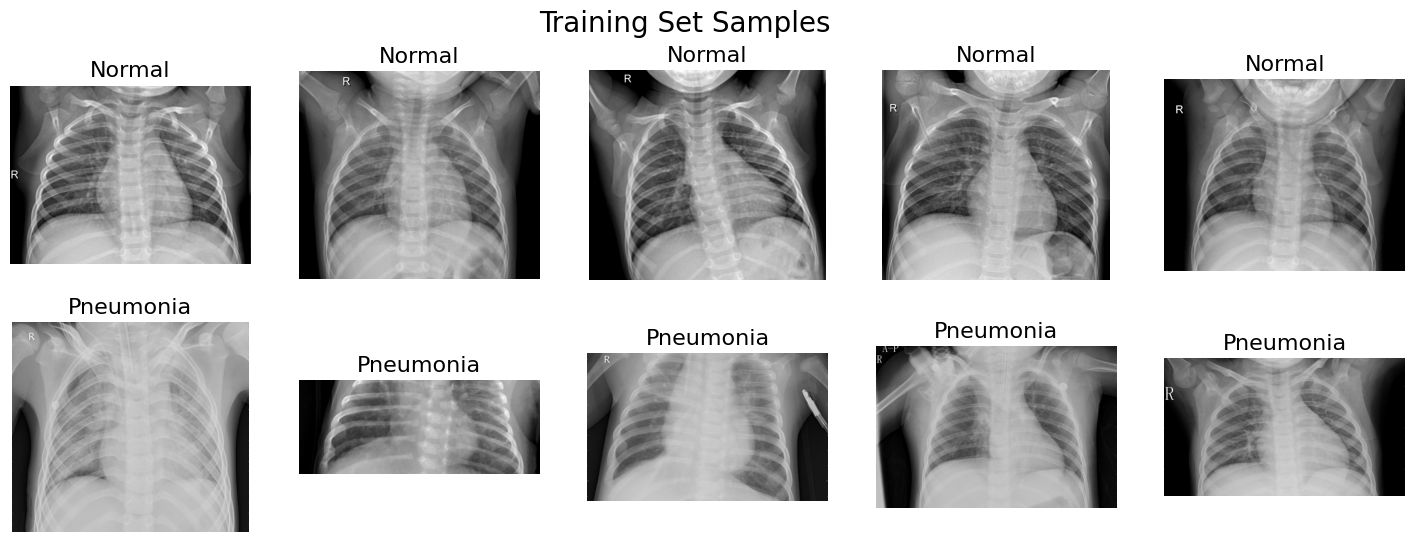

In [ ]:
#Plot some training set samples

def plot_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(18, 6))
    for i, path in enumerate(samples):
        image = cv2.imread(path)                  # BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # -> RGB
        ax[i//5][i%5].imshow(image)
        if i < 5:
            ax[i//5][i%5].set_title("Normal", fontsize=16)
        else:
            ax[i//5][i%5].set_title("Pneumonia", fontsize=16)
        ax[i//5][i%5].axis('off')

classes = ["NORMAL", "PNEUMONIA"]
rand_samples = []

for cls in classes:
    folder = os.path.join(data_dir, "train", cls)
    files = os.listdir(folder)
    rand_samples.extend(
        random.sample([os.path.join(folder, f) for f in files], 5)
    )

plot_samples(rand_samples)
plt.suptitle("Training Set Samples", fontsize=20)
plt.show()


In [ ]:
# EfficientNet-B4 model and train/validate functions

# Load pretrained EfficientNet-B4
model = models.efficientnet_b4(pretrained=True)

# Modify the classifier for binary classification (Normal vs Pneumonia)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 1)   # 1 logit for BCEWithLogitsLoss

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

from tqdm import tqdm

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.float().to(device)  # [batch]

        outputs = model(images).squeeze(1)  # [batch], fixes squeeze() issue
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = (torch.sigmoid(outputs) > 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.float().to(device)

            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).long()

            correct += (preds == labels.long()).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy, np.array(all_labels), np.array(all_preds)


c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Training loop and learning curves

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
num_epochs = 20   # change to e.g. 5 or 10 when you really train

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_y_true, val_y_pred = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}% | "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%")





Epoch 1/1


100%|██████████| 163/163 [00:31<00:00,  5.16it/s]


Train Loss=0.0157, Train Acc=99.50% | Val Loss=0.0366, Val Acc=100.00%


Test Loss: 0.2187
Test Accuracy: 94.71%


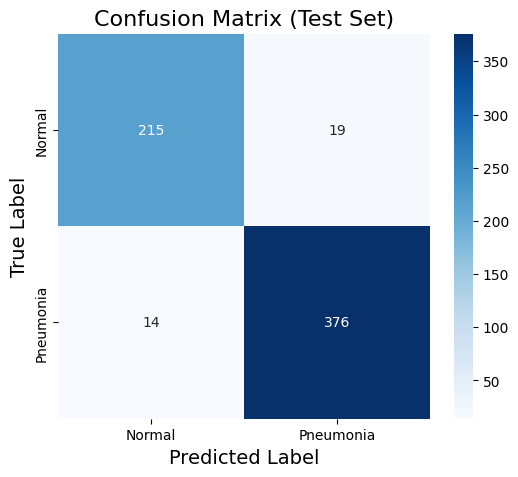

Accuracy  : 0.9471
Precision : 0.9519
Recall    : 0.9641
F1-score  : 0.9580

Classification report:
              precision    recall  f1-score   support

      Normal       0.94      0.92      0.93       234
   Pneumonia       0.95      0.96      0.96       390

    accuracy                           0.95       624
   macro avg       0.95      0.94      0.94       624
weighted avg       0.95      0.95      0.95       624



In [ ]:
# Final evaluation on TEST set (not val) and metrics

test_loss, test_acc, y_true, y_pred = validate(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Normal', 'Pneumonia'],
    yticklabels=['Normal', 'Pneumonia']
)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix (Test Set)', fontsize=16)
plt.show()

tn, fp, fn, tp = cm.ravel()

# Metrics based on y_true / y_pred (0 = Normal, 1 = Pneumonia)
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")

print("\nClassification report:")
print(classification_report(
    y_true,
    y_pred,
    labels=[0, 1],
    target_names=['Normal', 'Pneumonia']
))
